## Assignment 1 - Exploring CNNs on CIFAR-10 dataset
### Equipe:
- Kaleb Roncatti de Souza
- Nelson Gomes Brasil Junior

Todas as atividades são iniciadas em código por:
```
#################################################################
## Atividade X. Activity description
```

In [1]:
!pip3 install visualkeras

In [2]:
import tensorflow as tf
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import models
from sklearn.utils.class_weight import compute_class_weight
import visualkeras
import os
import random as rn
from keras import callbacks
from keras.activations import leaky_relu, relu, sigmoid
import seaborn as sns
from sklearn.metrics import confusion_matrix


rs = 321
# Setting up random state to specific seed so we can have reproductibility
os.environ['PYTHONHASHSEED']=str(rs)
np.random.seed(rs)
tf.random.set_seed(rs)
rn.seed(rs)

In [3]:
# Loading train and test set
(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

# Device that will be used to train the deep learning models
device = '/cpu:0' # or '/cpu:0' if you don't have GPU

In [4]:
# Function to shuffle
def shuffle_tensor(x: np.ndarray , y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices, seed=rs)
    return tf.gather(x, shuffled_indices), tf.gather(y, shuffled_indices)

# Function to split dataset
def split_dataset(x: np.ndarray, y: np.ndarray, percentage: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if len(x) != len(y):
        raise ValueError("array x and y must have the same length")
    
    # Shuffling dataset
    x, y = shuffle_tensor(x=x, y=y)

    # Finding the splits after shuffling
    total_elements = len(y)
    data = int(percentage * total_elements)
    return x[0:data], y[0:data], x[data:], y[data:]


In [5]:
# Function to plot accuracy and loss (train/validation)
def plot_train_val_acc_loss(model: tf.keras.Sequential(), model_name: str):
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title(f'model accuracy ({model_name})')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title(f'model loss ({model_name})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [6]:
#################################################################
## Atividade 1. Splitting training and validation
x_train, y_train, x_val, y_val = split_dataset(x=x_train, y=y_train, percentage = 0.8)
print(f"We splitted the training dataset using the following percentage: {len(x_train)/(len(x_train) + len(x_val))}")
print(f"Training dataset has the following shape: x ==> {x_train.shape}, y ==> {y_train.shape}")
print(f"Validation dataset has the following shape: x ==> {x_val.shape}, y ==> {y_val.shape}")

We splitted the training dataset using the following percentage: 0.8
Training dataset has the following shape: x ==> (40000, 32, 32, 3), y ==> (40000, 1)
Validation dataset has the following shape: x ==> (10000, 32, 32, 3), y ==> (10000, 1)


In [7]:
# Normalize data between [0, 1]
x_train = tf.cast(x_train, tf.float32) / 255.0
x_val = tf.cast(x_val, tf.float32) / 255.0
x_test = tf.cast(x_test, tf.float32) / 255.0


# One hot encoding on labels
num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)

(40000, 32, 32, 3) (40000, 10)


In [8]:
# Checking if we have a balanced dataset
# Para o conjunto de treino
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)))
unique, counts = np.unique(y_val, return_counts=True)
print("Validation ---> ", dict(zip(unique, counts)))

Train --->  {0: 4012, 1: 3998, 2: 4034, 3: 3993, 4: 4006, 5: 4007, 6: 4035, 7: 4006, 8: 3947, 9: 3962}
Validation --->  {0: 988, 1: 1002, 2: 966, 3: 1007, 4: 994, 5: 993, 6: 965, 7: 994, 8: 1053, 9: 1038}


We can consider that the dataset is more or less balanced. We could also adjust the weights based on their proportion, but for simplicity, let's keep going considering the dataset is completely balanced.

In [9]:
print(x_train[0].shape)


(32, 32, 3)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________


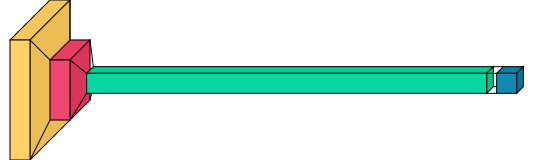

In [10]:
#################################################################
## Atividade 2. Creating a very simple convolutional neural net

def create_baseline_model(input_shape=x_train[0].shape, activation = relu) -> tf.keras.Sequential():
    model = tf.keras.Sequential()

    # Convolutional layer with 32 filters, 3x3 each
    model.add(
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=activation, 
            input_shape=x_train[0].shape))
    #Max pooling of size 3x3
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # Flattening
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(10))

    return model

model = create_baseline_model()
model.summary()
# Taking a look at the neural net
visualkeras.layered_view(model)


In [11]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
# Training the baseline model and saving it
with tf.device(device):
    model.fit(
        x_train, y_train_oh, 
        epochs=30, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/30
620/625 [============================>.] - ETA: 0s - loss: 1.5829 - accuracy: 0.4434
Epoch 1: val_loss improved from inf to 1.37244, saving model to weights_baseline.h5
625/625 [==============================] - 12s 18ms/step - loss: 1.5812 - accuracy: 0.4441 - val_loss: 1.3724 - val_accuracy: 0.5214
Epoch 2/30
621/625 [============================>.] - ETA: 0s - loss: 1.2848 - accuracy: 0.5534
Epoch 2: val_loss improved from 1.37244 to 1.28337, saving model to weights_baseline.h5
625/625 [==============================] - 15s 23ms/step - loss: 1.2842 - accuracy: 0.5536 - val_loss: 1.2834 - val_accuracy: 0.5455
Epoch 3/30
623/625 [============================>.] - ETA: 0s - loss: 1.1985 - accuracy: 0.5845
Epoch 3: val_loss improved from 1.28337 to 1.23583, saving model to weights_baseline.h5
625/625 [==============================] - 16s 25ms/step - loss: 1.1986 - accuracy: 0.5843 - val_loss: 1.2358 - val_accuracy: 0.5678
Epoch 4/30
625/625 [==============================] -

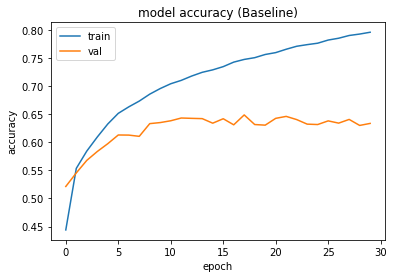

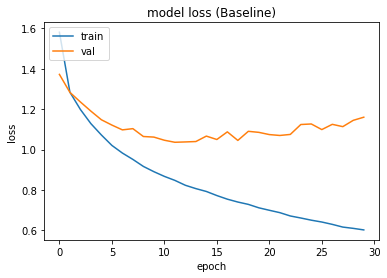

In [13]:
# Observing the model accuracy through the epochs
plot_train_val_acc_loss(model=model, model_name=f"Baseline")

In [14]:
#################################################################
## Atividade 3. Exploring OTHER two activation types, since we already played with ReLU

model_sigmoid = create_baseline_model(activation=sigmoid)
model_sigmoid.summary()
# Compiling the model
model_sigmoid.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_leaky_relu = create_baseline_model(activation=leaky_relu)
model_leaky_relu.summary()
# Compiling the model
model_leaky_relu.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)               

In [15]:
# Training the baseline model and saving it with OTHER ACTIVATIONS
# Sigmoid
print("Starting training baseline with sigmoid")
with tf.device(device):
    model_sigmoid.fit(
        x_train, y_train_oh, 
        epochs=30, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline_sigmoid.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

print("Starting training baseline with LeakyReLU")
# Leaky ReLU
with tf.device(device):
    model_leaky_relu.fit(
        x_train, y_train_oh, 
        epochs=30, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline_leaky_relu.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Starting training baseline with sigmoid
Epoch 1/30
621/625 [============================>.] - ETA: 0s - loss: 2.1349 - accuracy: 0.2482
Epoch 1: val_loss improved from inf to 1.96852, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 15s 23ms/step - loss: 2.1338 - accuracy: 0.2485 - val_loss: 1.9685 - val_accuracy: 0.2988
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.8877 - accuracy: 0.3377
Epoch 2: val_loss improved from 1.96852 to 1.84715, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 8s 13ms/step - loss: 1.8877 - accuracy: 0.3377 - val_loss: 1.8472 - val_accuracy: 0.3388
Epoch 3/30
620/625 [============================>.] - ETA: 0s - loss: 1.8082 - accuracy: 0.3675
Epoch 3: val_loss improved from 1.84715 to 1.81333, saving model to weights_baseline_sigmoid.h5
625/625 [==============================] - 12s 19ms/step - loss: 1.8077 - accuracy: 0.3677 - val_loss: 1.8133 - val_accurac

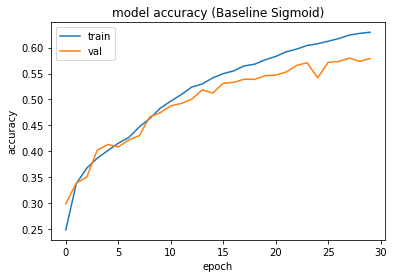

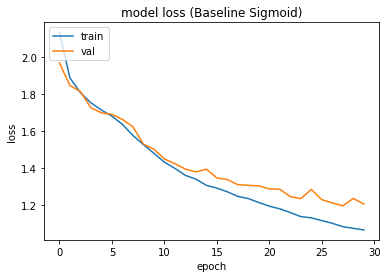

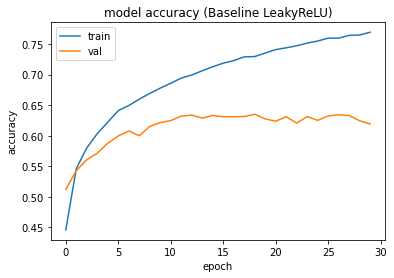

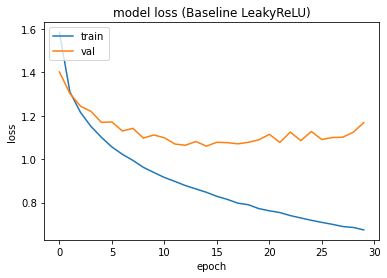

In [16]:
# Observing the model accuracy through the epochs for SIGMOID
plot_train_val_acc_loss(model=model_sigmoid, model_name=f"Baseline Sigmoid")

# Observing the model accuracy through the epochs for LeakyReLU
plot_train_val_acc_loss(model=model_leaky_relu, model_name=f"Baseline LeakyReLU")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                62730     
                                                                 
Total params: 72,874
Trainable params: 72,874
Non-trainable params: 0
__________________________________________________

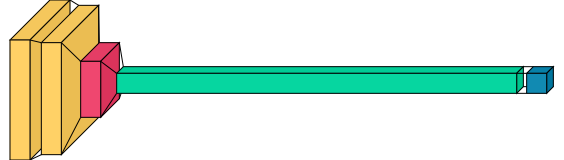

In [17]:
#################################################################
## Atividade 4. Exploring more complex CNNs to improve our model

model_complex = tf.keras.Sequential()

model_complex.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu))

model_complex.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Flattening
model_complex.add(layers.Flatten())
# Output layer
model_complex.add(layers.Dense(10))

model_complex.summary()
# Compiling the model
model_complex.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Taking a look at the neural net
visualkeras.layered_view(model_complex)

In [18]:
# Training model_complex
with tf.device(device):
    model_complex.fit(
        x_train, y_train_oh, 
        epochs=30, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_complex.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/30
624/625 [============================>.] - ETA: 0s - loss: 1.4882 - accuracy: 0.4733
Epoch 1: val_loss improved from inf to 1.26506, saving model to weights_complex.h5
625/625 [==============================] - 22s 34ms/step - loss: 1.4877 - accuracy: 0.4735 - val_loss: 1.2651 - val_accuracy: 0.5551
Epoch 2/30
623/625 [============================>.] - ETA: 0s - loss: 1.1471 - accuracy: 0.6020
Epoch 2: val_loss improved from 1.26506 to 1.11505, saving model to weights_complex.h5
625/625 [==============================] - 20s 33ms/step - loss: 1.1469 - accuracy: 0.6020 - val_loss: 1.1151 - val_accuracy: 0.6114
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.0275 - accuracy: 0.6479
Epoch 3: val_loss improved from 1.11505 to 1.05584, saving model to weights_complex.h5
625/625 [==============================] - 21s 33ms/step - loss: 1.0275 - accuracy: 0.6479 - val_loss: 1.0558 - val_accuracy: 0.6319
Epoch 4/30
625/625 [==============================] - ET

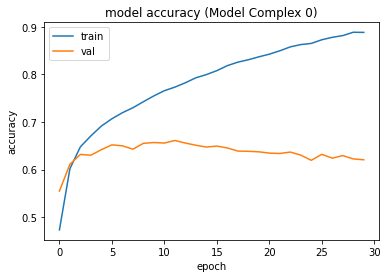

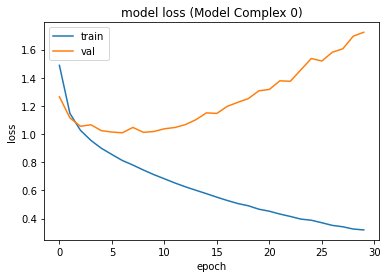

In [19]:
# Observing the model accuracy through the epochs for model complex 0
plot_train_val_acc_loss(model=model_complex, model_name=f"Model Complex 0")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                  

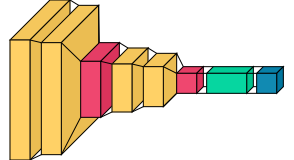

In [20]:
# Creating another model
model_complex_1 = tf.keras.Sequential()

model_complex_1.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex_1.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu))

model_complex_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_complex_1.add(
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex_1.add(
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu))

model_complex_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flattening
model_complex_1.add(layers.Flatten())
# Output layer
model_complex_1.add(layers.Dense(10))

model_complex_1.summary()
# Compiling the model
model_complex_1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Taking a look at the neural net
visualkeras.layered_view(model_complex_1)

In [21]:
# Training it
with tf.device(device):
    model_complex_1.fit(
        x_train, y_train_oh, 
        epochs=30, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_complex_1.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/30
623/625 [============================>.] - ETA: 0s - loss: 1.6669 - accuracy: 0.3884
Epoch 1: val_loss improved from inf to 1.39993, saving model to weights_complex_1.h5
625/625 [==============================] - 25s 39ms/step - loss: 1.6659 - accuracy: 0.3889 - val_loss: 1.3999 - val_accuracy: 0.4948
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.3377 - accuracy: 0.5236
Epoch 2: val_loss improved from 1.39993 to 1.27846, saving model to weights_complex_1.h5
625/625 [==============================] - 24s 39ms/step - loss: 1.3377 - accuracy: 0.5236 - val_loss: 1.2785 - val_accuracy: 0.5376
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.2088 - accuracy: 0.5717
Epoch 3: val_loss improved from 1.27846 to 1.15459, saving model to weights_complex_1.h5
625/625 [==============================] - 23s 37ms/step - loss: 1.2088 - accuracy: 0.5717 - val_loss: 1.1546 - val_accuracy: 0.5930
Epoch 4/30
625/625 [==============================

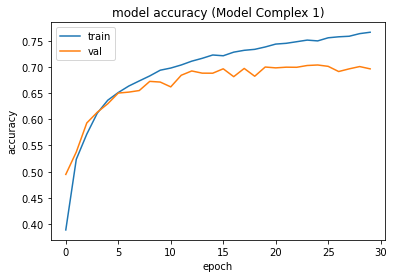

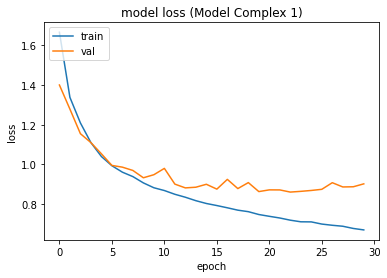

In [22]:
# Observing the model accuracy through the epochs for model complex 1
plot_train_val_acc_loss(model=model_complex_1, model_name=f"Model Complex 1")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                  

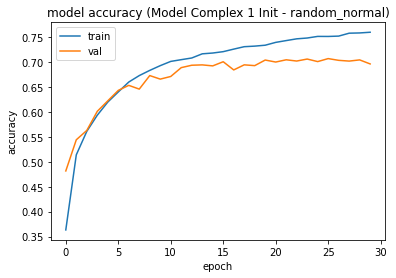

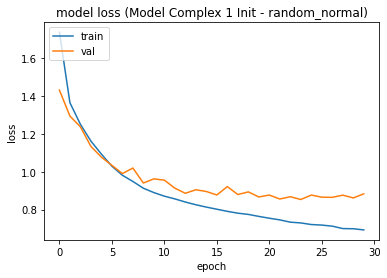

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                  

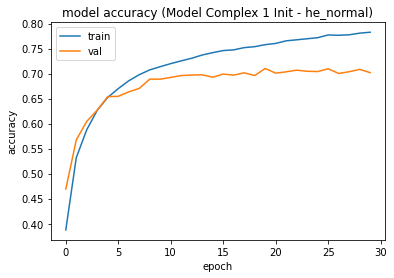

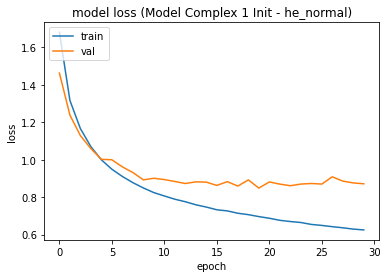

In [23]:
#################################################################
## Atividade 5. Exploring different types of initialization and regularization

## Varying the initialization ##
# We are going to use the same models as model_complex_1
# Since the glorot_uniform is the default, we are going to test
# ["random_normal", "he_normal"]


inits = ["random_normal", "he_normal"]
models_init = []
for initialization in inits:

    model_tmp = tf.keras.Sequential()

    model_tmp.add(
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=leaky_relu, 
            input_shape=x_train[0].shape,
            kernel_initializer=initialization))
    model_tmp.add(
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=leaky_relu,
            kernel_initializer=initialization))

    model_tmp.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model_tmp.add(
        layers.Conv2D(
            filters=16, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=leaky_relu, 
            input_shape=x_train[0].shape,
            kernel_initializer=initialization))
    model_tmp.add(
        layers.Conv2D(
            filters=16, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=leaky_relu,
            kernel_initializer=initialization))

    model_tmp.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model_tmp.add(layers.Flatten())
    # Output layer
    model_tmp.add(layers.Dense(10, kernel_initializer=initialization))

    model_tmp.summary()
    # Compiling the model
    model_tmp.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # Training model
    with tf.device(device):
        model_tmp.fit(
            x_train, y_train_oh, 
            epochs=30, 
            batch_size=64,
            validation_data=(x_val, y_val_oh),
            verbose=1,
            callbacks=[
                callbacks.TerminateOnNaN(),
                callbacks.ModelCheckpoint(
                    f'weights_complex_1_init-{initialization}.h5',
                    save_best_only=True,
                    verbose=1),
            ]
            )

    models_init.append(model_tmp)
    # Observing results
    plot_train_val_acc_loss(model=model_tmp, model_name=f"Model Complex 1 Init - {initialization}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 conv2d_20 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                 

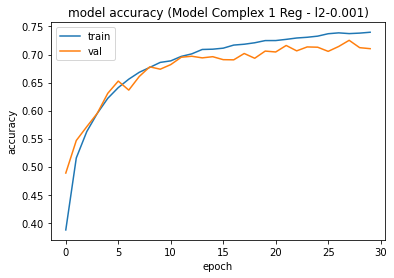

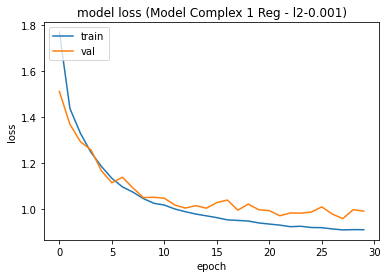

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 conv2d_24 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                

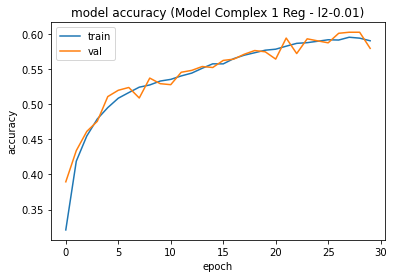

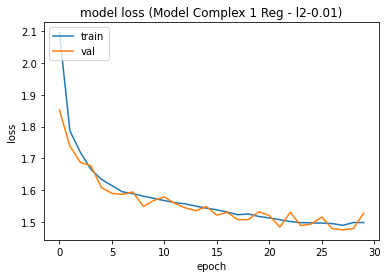

In [24]:
## Varying the regularization using the default initializer (Glorot/Bengio: glorot_uniform) ##
# We are going to use the same models as model_complex_1


regs = [regularizers.l2(0.001), regularizers.l2(0.01)]
regs_str = ["l2-0.001", "l2-0.01"]
models_reg = []
acc = 0
for regularization in regs:

    model_tmp = tf.keras.Sequential()

    model_tmp.add(
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=leaky_relu, 
            input_shape=x_train[0].shape,
            kernel_regularizer=regularization))
    model_tmp.add(
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=leaky_relu,
            kernel_regularizer=regularization))

    model_tmp.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model_tmp.add(
        layers.Conv2D(
            filters=16, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=leaky_relu, 
            input_shape=x_train[0].shape,
            kernel_regularizer=regularization))
    model_tmp.add(
        layers.Conv2D(
            filters=16, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation=leaky_relu,
            kernel_regularizer=regularization))

    model_tmp.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model_tmp.add(layers.Flatten())
    # Output layer
    model_tmp.add(layers.Dense(10, kernel_regularizer=regularization))

    model_tmp.summary()
    # Compiling the model
    model_tmp.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # Training model
    with tf.device(device):
        model_tmp.fit(
            x_train, y_train_oh, 
            epochs=30, 
            batch_size=64,
            validation_data=(x_val, y_val_oh),
            verbose=1,
            callbacks=[
                callbacks.TerminateOnNaN(),
                callbacks.ModelCheckpoint(
                    f'weights_complex_1_reg-{regs_str[acc]}.h5',
                    save_best_only=True,
                    verbose=1),
            ]
            )
    
    models_reg.append(model_tmp)
    
    # Observing results
    plot_train_val_acc_loss(model=model_tmp, model_name=f"Model Complex 1 Reg - {regs_str[acc]}")
    acc += 1

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 conv2d_28 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                

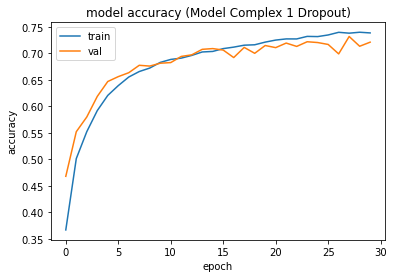

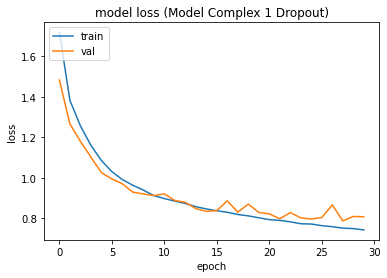

In [25]:
#################################################################
## Atividade 6. Exploring Droupout
# Using it before the fully connected (dense) layer as suggested by Hinton (2012)
# https://arxiv.org/pdf/1207.0580.pdf

model_complex_1_dropout = tf.keras.Sequential()

model_complex_1_dropout.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex_1_dropout.add(
    layers.Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu))

model_complex_1_dropout.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_complex_1_dropout.add(
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu, 
        input_shape=x_train[0].shape))
model_complex_1_dropout.add(
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        padding='valid', 
        activation=leaky_relu))

model_complex_1_dropout.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flattening
model_complex_1_dropout.add(layers.Flatten())

# Dropout layer
model_complex_1_dropout.add(layers.Dropout(0.2))

# Output layer
model_complex_1_dropout.add(layers.Dense(10))

model_complex_1_dropout.summary()
# Compiling the model
model_complex_1_dropout.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

with tf.device(device):
    model_complex_1_dropout.fit(
        x_train, y_train_oh, 
        epochs=30, 
        batch_size=64,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_complex_1_dropout.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

# Observing the model accuracy
plot_train_val_acc_loss(model=model_complex_1_dropout, model_name="Model Complex 1 Dropout")

In [26]:
#################################################################
## Atividade 7. Plotting Loss VS Epochs
## JÁ PLOTAMOS OS GRÁFICOS CONFORME DESENVOLVEMOS OS MODELOS

#### Atividate 7. Análise
Treinamos múltiplos modelos utilizando redes neurais do tipo convolucional. No que diz respeito a overfitting ser observado (ou não), vamos analisar caso a caso:
- **Modelo baseline:**
Quando observamos
- **Modelo baseline editado com ativação sigmoide:**
- **Modelo baseline editado com ativação LeakyReLU:**
- **Modelo complexo 0:**
- **Modelo complexo 1:**
- **Modelo complexo 1 com inicialização tipo `random_normal`:**
- **Modelo complexo 1 com inicialização tipo `he_normal`:**
- **Modelo complexo 1 com regularização tipo `l2-0.001`:**
- **Modelo complexo 1 com regularização tipo `l2-0.01`:**
- **Modelo complexo 1 com `Dropout`:**

In [27]:
#################################################################
## Atividade 8. Choosing best model and fitting the test set


# Searching score
score = model_complex_1_dropout.evaluate(x_test, y_test_oh, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT BALANCED):', score[1])

# Applying predict after model training
probs = model_complex_1_dropout.predict(x_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.8142 - accuracy: 0.7184
Test loss: 0.8142431378364563
Test accuracy (NOT BALANCED): 0.7184000015258789
313/313 [==============================] - 2s 5ms/step


Matriz de confusão


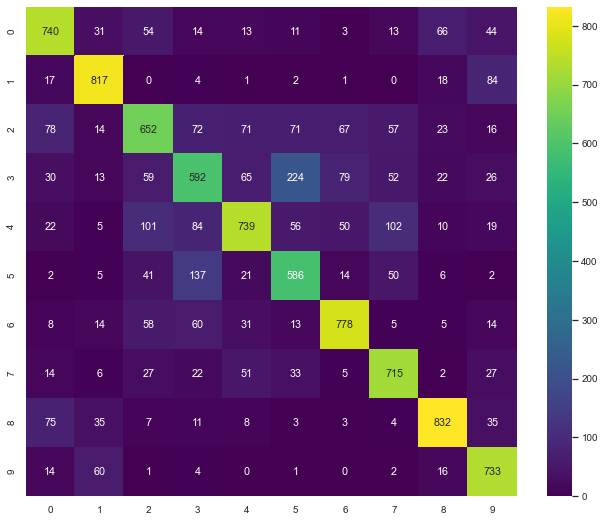

In [28]:
cm = confusion_matrix(np.argmax(probs, axis=1), y_test)
print("Matriz de confusão")
plt.figure(figsize = (11,9))
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')